<a href="https://colab.research.google.com/github/felipeanndrade/lfp_hg_hfo_dsp/blob/main/lfp_dsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# NOTA: loadmat do scipy nao eh compativel com a versao 7.3
# Usar a versao atual do matlab levanta o problema de salvar arquivos
# na versao 7.3; Eis uma helper function para lidar com essa questao:
import h5py
import numpy as np

def loadmat_to_np(mat_file_path, var_names):
    data = {}
    with h5py.File(mat_file_path, 'r') as f:
        for var_name in var_names:
            dataset = f[var_name]
            data[var_name] = np.array(dataset, dtype=np.float64)
    return data

In [ ]:
# Transformando as variaveis do arquivo matlab para tensores
mat_file_name = '/content/drive/MyDrive/LFP_HG_HFO.mat'
mat_variables = ("lfpHG", "lfpHFO")

LFP_HG_HFO = loadmat_to_np(mat_file_name, mat_variables)
LFP_HG = LFP_HG_HFO['lfpHG']
LFP_HFO = LFP_HG_HFO['lfpHFO']

In [ ]:
# Definindo a frequencia
srate = 1000
dt = 1/srate

In [ ]:
# Duracao do registro (por que?)
d_HG = LFP_HG * dt
d_HFO = LFP_HFO * dt

In [ ]:
# Definindo o vetor de tempo
t_HG = np.arange(len(LFP_HG)) * dt
t_HFO = np.arange(len(LFP_HFO)) * dt

In [ ]:
# Padronizacao do tamanhos dos plots
import matplotlib.pyplot as plt

def figure_size(): return plt.figure(figsize=(12, 4))
def plot_tight():
  plt.tight_layout()
  plt.show()

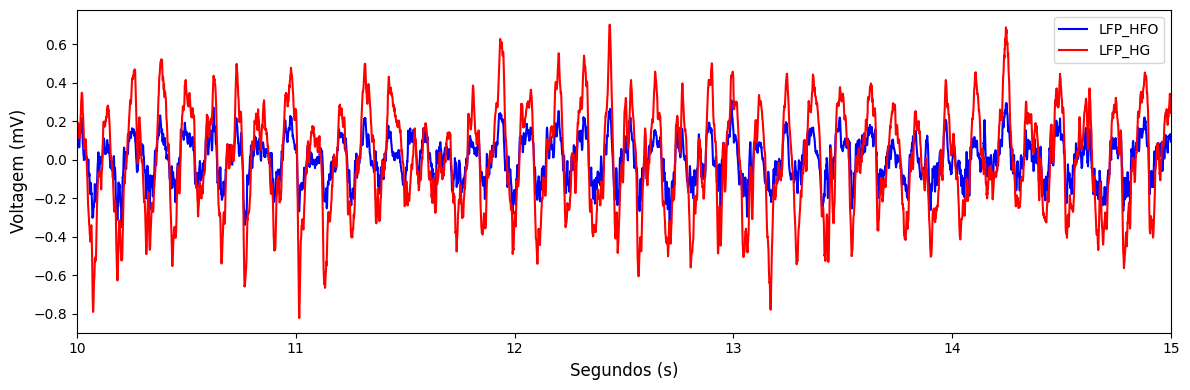

In [ ]:
# Plotando os canais no intervalo de 10 a 15 segundos
time_start = 10
time_end = 15

idx_HFO = np.logical_and(t_HFO >= time_start, t_HFO <= time_end)
idx_HG = np.logical_and(t_HG >= time_start, t_HG <= time_end)

figure_size()
plt.plot(t_HFO[idx_HFO], LFP_HFO[idx_HFO], color='blue', label='LFP_HFO')
plt.plot(t_HG[idx_HG], LFP_HG[idx_HG], color='red', label='LFP_HG')
plt.xlim(time_start, time_end)
plt.ylabel('Voltagem (mV)', fontsize=12)
plt.xlabel('Segundos (s)', fontsize=12)
plt.legend(loc='upper right')
plot_tight()

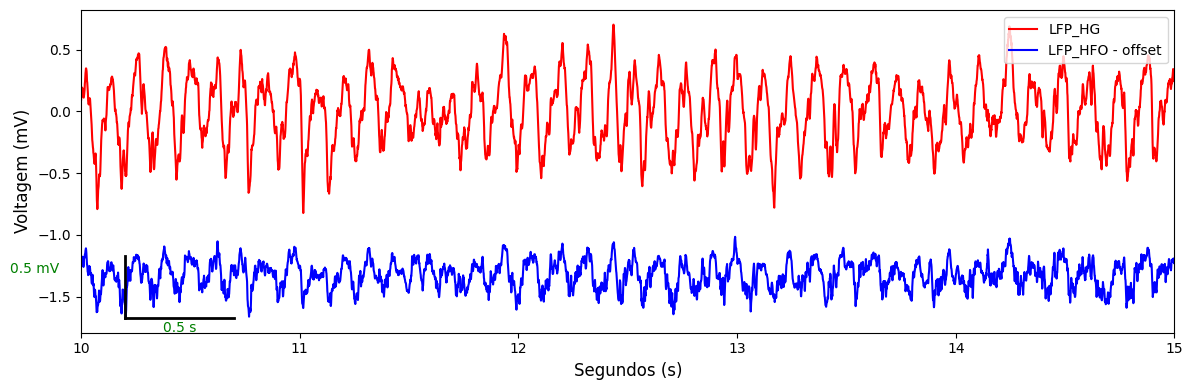

In [ ]:
# Plotando os canais com barra de calibragem
offset = np.max(np.abs(LFP_HG[idx_HG])) + 0.5
yc = np.min(LFP_HFO[idx_HFO] - offset)

# Coordenadas da barra de calibragem para evitar sobreposicao
x_bar_start_offset = time_start + 0.2
x_bar_end_offset = time_start + 0.7
y_bar_start_offset = time_start + 0.2
y_bar_end_offset = time_start + 0.2
x_bar_leg_start_offset = time_start + 0.45
x_bar_leg_end_offset = yc - 0.02
y_bar_leg_start_offset = time_start - 0.1
y_bar_leg_end_offset = yc + 0.40

figure_size()
plt.plot(t_HG[idx_HG], LFP_HG[idx_HG], color='red', label='LFP_HG')
plt.plot(t_HFO[idx_HFO], LFP_HFO[idx_HFO] - offset, color='blue', label='LFP_HFO - offset')
plt.plot([x_bar_start_offset, x_bar_end_offset], [yc, yc], 'k', lw=2)
plt.plot([y_bar_start_offset, y_bar_end_offset], [yc, yc + 0.5], 'k', lw=2)
plt.text(x_bar_leg_start_offset, x_bar_leg_end_offset, '0.5 s', va='top', ha='center', color='green')
plt.text(y_bar_leg_start_offset, y_bar_leg_end_offset, '0.5 mV', va='center', ha='right', color='green')
plt.xlim(time_start, time_end)
plt.ylabel('Voltagem (mV)', fontsize=12)
plt.xlabel('Segundos (s)', fontsize=12)
plt.legend(loc='upper right')
plot_tight()

In [ ]:
# Definindo os parametros para o power welch
from scipy.signal import welch

m_nperseg = min(int(2 *srate), len(LFP_HG))
m_noverlap = m_nperseg // 2
m_nfft = int(2 ** int(np.ceil(np.log2(srate / 0.1))))

f_HG, Pxx_HG = welch(LFP_HG.ravel(), fs=srate, window='hann', nperseg=m_nperseg, nfft=m_nfft)
f_HFO, Pxx_HFO = welch(LFP_HFO.ravel(), fs=srate, window='hann', nperseg=m_nperseg, nfft=m_nfft)

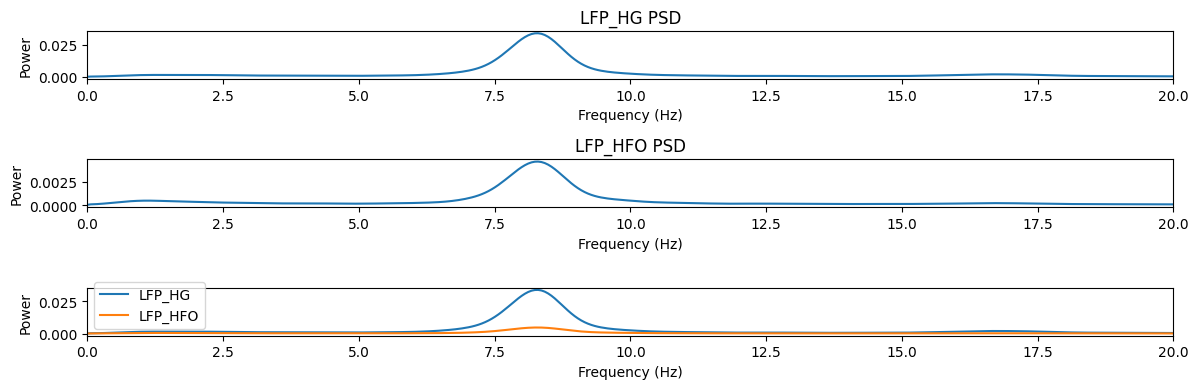

In [ ]:
# Plotando a PSD de cada canal e as duas juntas.
figure_size()
PSD_HG = plt.subplot(3, 1, 1)
PSD_HG.plot(f_HG, Pxx_HG)
PSD_HG.set_xlim(0, 20)
PSD_HG.set_xlabel('Frequency (Hz)')
PSD_HG.set_ylabel('Power')
PSD_HG.set_title('LFP_HG PSD')

PSD_HFO = plt.subplot(3, 1, 2)
PSD_HFO.plot(f_HFO, Pxx_HFO)
PSD_HFO.set_xlim(0, 20)
PSD_HFO.set_xlabel('Frequency (Hz)')
PSD_HFO.set_ylabel('Power')
PSD_HFO.set_title('LFP_HFO PSD')

PSD_HG_HFO = plt.subplot(3, 1, 3)
PSD_HG_HFO.plot(f_HG, Pxx_HG, label='LFP_HG')
PSD_HG_HFO.plot(f_HFO, Pxx_HFO, label='LFP_HFO')
PSD_HG_HFO.set_xlim(0, 20)
PSD_HG_HFO.set_xlabel('Frequency (Hz)')
PSD_HG_HFO.set_ylabel('Power')
PSD_HG_HFO.legend()

plot_tight()

In [ ]:
# Computando a banda theta
band = np.logical_and(f_HG >= 5, f_HG <= 10)
df = f_HG[1] - f_HG[0]
theta_HG= np.sum(Pxx_HG[band]) * df
theta_HFO = np.sum(Pxx_HFO[band]) * df

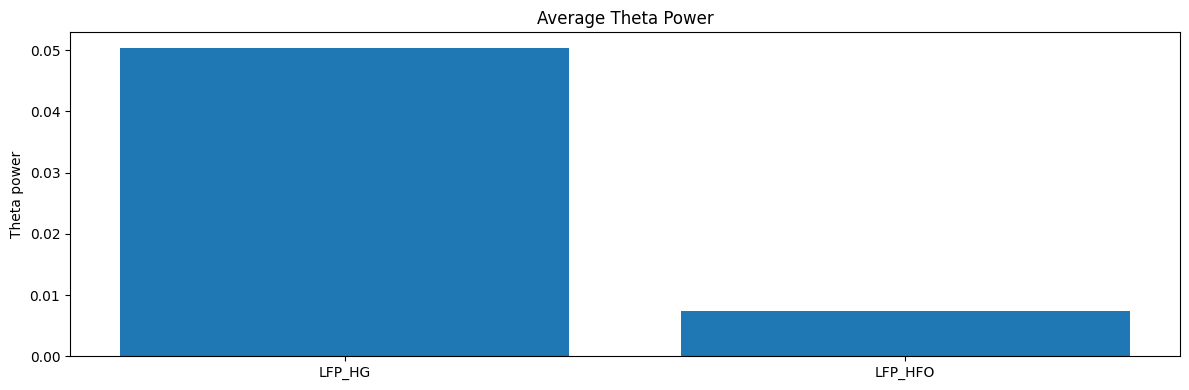

In [ ]:
# Plotando os canais em banda
figure_size()
channels = ['LFP_HG', 'LFP_HFO']
theta_vals = [theta_HG, theta_HFO]
plt.bar(channels, theta_vals)
plt.ylabel('Theta power')
plt.title('Average Theta Power')
plot_tight()

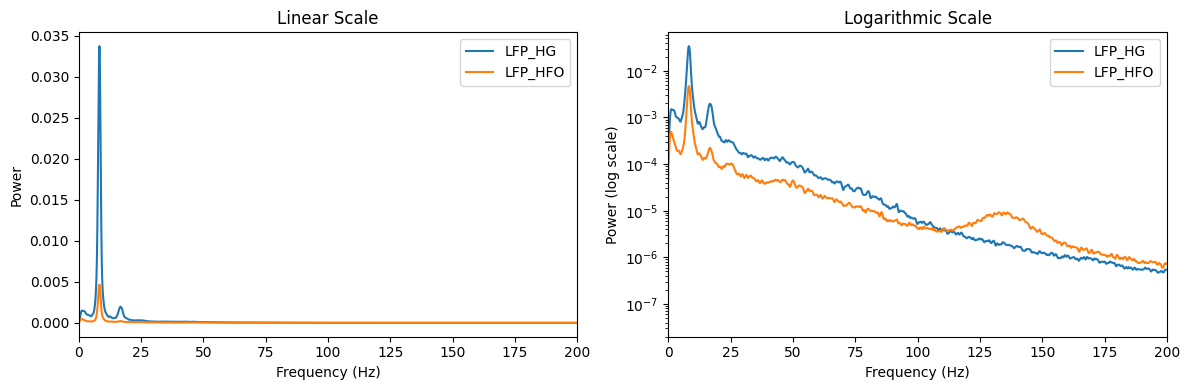

In [ ]:
# Plotando PSD em escala normal entre 0 e 200 Hz no eixo X e em escala
# logaritmica no eixo Y

figure_size()

PSD_HG_HFO_N = plt.subplot(1, 2, 1)
PSD_HG_HFO_N.plot(f_HG, Pxx_HG, label='LFP_HG')
PSD_HG_HFO_N.plot(f_HFO, Pxx_HFO, label='LFP_HFO')
PSD_HG_HFO_N.set_xlim(0, 200)
PSD_HG_HFO_N.set_xlabel('Frequency (Hz)')
PSD_HG_HFO_N.set_ylabel('Power')
PSD_HG_HFO_N.legend()
PSD_HG_HFO_N.set_title('Linear Scale')

PSD_HG_HFO_LOG = plt.subplot(1, 2, 2)
PSD_HG_HFO_LOG.plot(f_HG, Pxx_HG, label='LFP_HG')
PSD_HG_HFO_LOG.plot(f_HFO, Pxx_HFO, label='LFP_HFO')
PSD_HG_HFO_LOG.set_xlim(0, 200)
PSD_HG_HFO_LOG.set_yscale('log')
PSD_HG_HFO_LOG.set_xlabel('Frequency (Hz)')
PSD_HG_HFO_LOG.set_ylabel('Power (log scale)')
PSD_HG_HFO_LOG.legend()
PSD_HG_HFO_LOG.set_title('Logarithmic Scale')

plot_tight()

In [ ]:
# PSD para o sinal LFP_HG com vetor de frequencia de 0 a 15 Hz
f_0_15 = np.arange(0, 15 + 0.01, 0.01)
m_nfft2 = int(2 ** int(np.ceil(np.log(srate / 0.01))))

# Sinal completo
f_full, P_full = welch(LFP_HG.ravel(), fs=srate, window='hann',
                       nperseg=m_nperseg, noverlap=m_noverlap, nfft=m_nfft2)
# Janela de 1 segundo
f_1s, P_1s = welch(LFP_HG.ravel(), fs=srate, window='hann',
                   nperseg=srate, noverlap=srate//2, nfft=m_nfft2)

P_full_i = np.interp(f_0_15, f_full, P_full)
P_1s_i = np.interp(f_0_15, f_1s, P_1s)

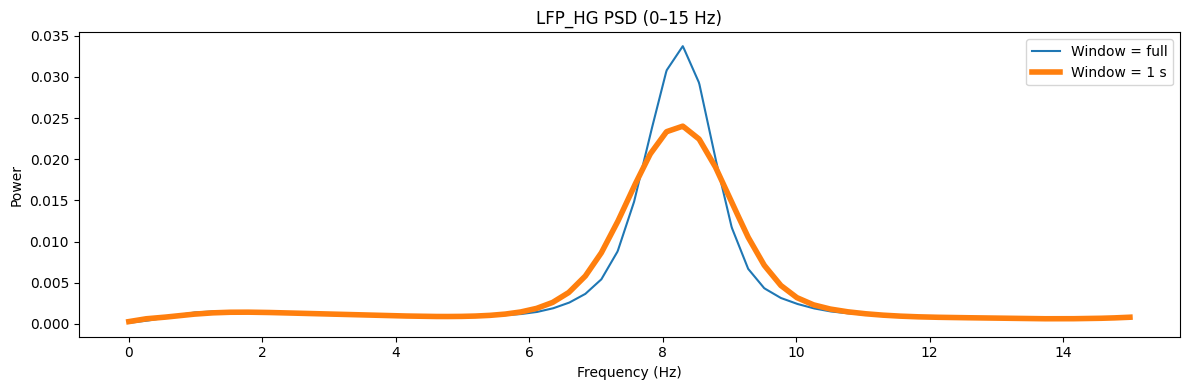

In [ ]:
figure_size()

plt.plot(f_0_15, P_full_i, label='Window = full')
plt.plot(f_0_15, P_1s_i, linewidth=4, label='Window = 1 s')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('LFP_HG PSD (0–15 Hz)')
plt.legend()

plot_tight()

In [ ]:
# PSD para o sinal LFP_HFO com vetor de frequencia de 100 a 150 Hz
f_100_150 = np.arange(100, 150 + 0.01, 0.01)
m_nperseg2 = min(int(2 *srate), len(LFP_HFO))

# Sinal completo
f_full2, P_full2 = welch(LFP_HFO.ravel(), fs=srate, window='hann',
                         nperseg=m_nperseg2, noverlap=m_nperseg2//2, nfft=m_nfft2)

# Janela de 1 segundo
f_1s2, P_1s2 = welch(LFP_HFO.ravel(), fs=srate, window='hann',
                     nperseg=srate, noverlap=srate//2, nfft=m_nfft2)

P_full2_i = np.interp(f_100_150, f_full2, P_full2)
P_1s2_i = np.interp(f_100_150, f_1s2, P_1s2)

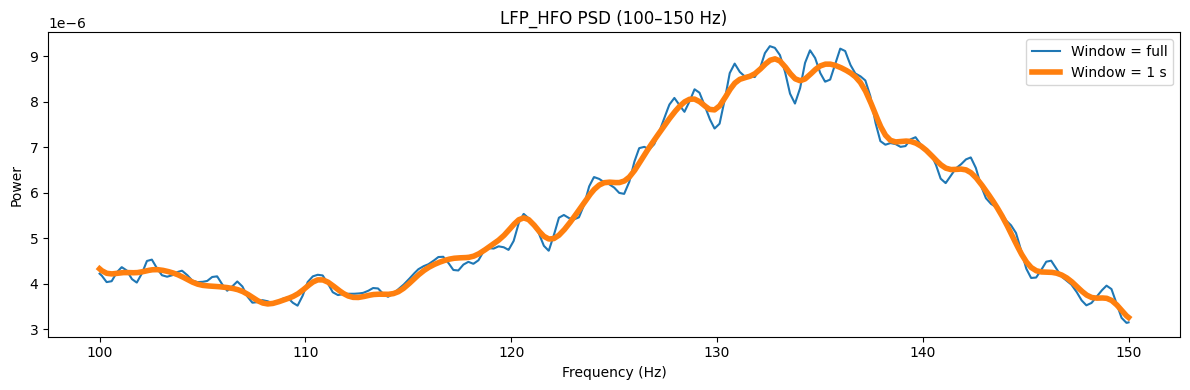

In [ ]:
figure_size()

plt.plot(f_100_150, P_full2_i, label='Window = full')
plt.plot(f_100_150, P_1s2_i, linewidth=4, label='Window = 1 s')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('LFP_HFO PSD (100–150 Hz)')
plt.legend()

plot_tight()